# Producción Agricola

## Conocimiento del Negocio

### Dataset

Repositorio en google drive:

- [Producción Agricola](https://drive.google.com/file/d/1uJKy2HI79gER4ThgYHVoHQ3wSTMm81Do/view?usp=drive_link)

### Contexto

El análisis de los datos puede ayudar a los agricultores a tomar decisiones informadas sobre qué cultivos plantar en base a factores históricos, y también puede ser útil para las empresas que compran cultivos a los agricultores para estimar su valor de mercado. \
Asimismo, este análisis puede ser útil para el gobierno para diseñar políticas que promuevan la producción agrícola y la seguridad alimentaria.

## Campos

- año
- provincia
- cultivo
- precipitación (mm)
- área cosechada (acres)
- rendimiento (toneladas/acres)
- producción (toneladas)
- valor en finca ($)

### Objetivo

proporcionar una herramienta que permita estimar el valor de venta de diferentes cultivos agrícolas en base a datos históricos de producción

### Requirements

Ejecute el siguiente comando para instalar los paquetes necesarios:

```bash
pip install -r requirements.txt
```

## Extracción de Datos

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('agriculturalProduction.csv')
# Muestra las primeras filas del DataFrame
# print(df.head())

## Preparación y transformación de datos

**Limpieza de los datos:**

- Busco valores nulos en las columnas
  - Observo que hay valores nulos en las columnas:
    - precipitación
    - área cosechada
    - rendimiento
    - producción
    - valor en finca
  - Se eliminan los datos de la provincia NL dado que la mayoría de los datos son nulos
  - Se resuelve los valores nulos de precipitación asignando el valor medio por provincia y año a los valores nulos
  - Se resuelve los valores nulos de área cosechada asignando la predicción por provincia , cultivo y año
  - Se resuelve los valores nulos de rendimiento asignando la predicción por provincia , cultivo y año
  - Se resuelve los valores nulos de producción calculando el producto de área cosechada por el rendimiento

**Agregado de columnas:**

Una vez resueltos todos los valores nulos se procede a calcular y agregar las siguientes columnas:

- **farm_gate_value_per_ton**: valor en finca por tonelada
- **farm_gate_value_per_acre**: valor en finca por acre


In [37]:
# Obtener la cantidad de datos nulos por columna
datos_nulos_por_columna = df.isnull().sum()
print(datos_nulos_por_columna)

year                        0
province                    0
crop                        0
precipitation(mm)         140
harvested area (acres)    116
yield (tonnes/acres)      118
production (tonnes)       113
farm gate value ($)       139
dtype: int64


### Resolución de valores nulos en la columna precipitación

Análisis de los valores nulos en la columna precipitación
- Observo que la provincia NL tiene todos valores nulos en precipitación , por lo cual decido eliminar esta provincia del dataset
- Para los otros casos, decido reemplazar los valores nulos por el promedio por provincia y año

In [38]:
# Obtengo la cantidad de datos nulos en 'precipitation(mm) por año y provincia
precipitation_null_by_year_province = df.groupby(['province', 'year']).agg({'precipitation(mm)': lambda x: x.isnull().sum()})
precipitation_null_by_year_province = precipitation_null_by_year_province[precipitation_null_by_year_province.sum(axis=1) > 0]
# print(precipitation_null_by_year_province)

# Obtener la cantidad de valores no nulos en 'precipitation(mm)' para la provincia de 'NL'
precipitation_not_null_by_province_NL = df[df['province'] == 'NL']['precipitation(mm)'].count()
# Mostrar los resultados
print(f"Precipitation not null by NL: {precipitation_not_null_by_province_NL}")

# Crear un nuevo DataFrame sin las filas donde la provincia es 'NL'
df2 = df[df['province'] != 'NL'].copy()
# df2.describe()

# Calcular la media de precipitación por provincia y año y agregarla al DataFrame y se reemplazan los valores nulos por la media
precipitation_mean = df2.groupby(['year', 'province'])['precipitation(mm)'].mean().reset_index()
df2 = pd.merge(df2, precipitation_mean, on=['year', 'province'], suffixes=('', '_mean'))
# Rellenar los valores nulos en 'precipitation(mm)' con la media sin usar inplace
df2['precipitation(mm)'] = df2['precipitation(mm)'].fillna(df2['precipitation(mm)_mean'])


Precipitation not null by NL: 0


### Análisis de los datos nulos pendientes de resolución

In [39]:
datos_nulos_por_columna = df2.isnull().sum()
print(datos_nulos_por_columna)
filas_con_nulos = df2[df2.isnull().any(axis=1)]
# print(filas_con_nulos[['harvested area (acres)','yield (tonnes/acres)','production (tonnes)']])

year                       0
province                   0
crop                       0
precipitation(mm)          0
harvested area (acres)    14
yield (tonnes/acres)      16
production (tonnes)       15
farm gate value ($)       17
precipitation(mm)_mean     0
dtype: int64


Se crea una función que permite analizar los datos nulos pendientes de resolución y asignar un valor de predicción en base a la columna que se le pase como parámetro , el cultivo y la provincia

In [40]:
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame

# Función para resolver los valores nulos en un campo y asignar la predicción
def solve_nulls_in_field_and_assign_prediction(dataset: DataFrame, field: str, crop: str, province: str):
    # Obtener las filas que cumplen con las condiciones
    data = dataset[(dataset['crop'].str.strip() == crop) & (dataset['province'].str.strip() == province) & (dataset[field].notna())]
    # Calcular la media de toneladas por acre agrupado por año
    tonnes_by_year = data.groupby(['year'])[field].mean().reset_index()
    years = tonnes_by_year['year'].values.reshape(-1, 1)
    tonnes_by_acres =  tonnes_by_year[field].values.reshape(-1, 1)
    # Crear el modelo de regresión para predecir las toneladas por acre por año
    regression = RandomForestRegressor(n_estimators=50, random_state=0)
    regression.fit(years, tonnes_by_acres.ravel())  # Utilizar ravel() para convertir a array unidimensional
    # Se busca los años donde el valor de 'yield (tonnes/acres)' es nulo o cero
    nulls = dataset[(dataset['crop'].str.strip() == crop) & 
                    (dataset['province'].str.strip() == province) & 
                    (dataset[field].isnull() | (dataset[field] == 0))]    
    nulls = nulls[['year', field]]
    # Se realiza la predicción para los años para los valores nulos 
    for index, row in nulls.iterrows():
        # Obtener el valor de 'year' en la fila actual
        year = row['year'].astype(int)        
        # Realizar la predicción para el año actual
        prediction = regression.predict([[year]])[0].round(2)        
        # Mostrar el resultado
        print(f'Año: {year}, Predicción {field}: {prediction}')
        # Establecer un nuevo valor en la columna 'production' para las filas que cumplen con las condiciones
        dataset.loc[(dataset['year'].astype(int) == year) & 
                    (dataset['province'].str.strip() == province) & 
                    (dataset['crop'].str.strip() == crop) & 
                    (dataset[field].isnull() | (dataset[field] == 0)), field] = prediction
    # Gráfico con las toneladas por acre por año y la predicción
    # plt.scatter(tonnes_by_year['year'], tonnes_by_year[field], color = "red")
    # plt.plot(years, regression.predict(years), color = "blue")
    # plt.title(f"{field} por {province} y {crop}")
    # plt.xlabel("Año")
    # plt.ylabel(field)
    # plt.show()
    

### Resolución de valores nulos en la columna "harvested area (acres)"

- Se resuelve los valores nulos asignando la predicción de acuerdo al ano por cultivo y provincia

In [41]:
# Se busca los valores nulos por provincia y cultivo y se asigna el valor de la predicción
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'BC')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'potato', 'BC')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'MB')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'NB')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'NS')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'potato', 'NS')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'ON')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'PE')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'QC')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'potato', 'QC')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'corn', 'SK')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'potato', 'SK')
solve_nulls_in_field_and_assign_prediction(df2,'harvested area (acres)', 'oat', 'SK')

Año: 1997, Predicción harvested area (acres): 902.2
Año: 2022, Predicción harvested area (acres): 354.76
Año: 2022, Predicción harvested area (acres): 292.08
Año: 2022, Predicción harvested area (acres): 414.74
Año: 2022, Predicción harvested area (acres): 19325.4
Año: 1999, Predicción harvested area (acres): 64.74
Año: 2001, Predicción harvested area (acres): 54.7
Año: 2004, Predicción harvested area (acres): 70.6
Año: 2015, Predicción harvested area (acres): 54.68
Año: 2016, Predicción harvested area (acres): 54.8
Año: 2022, Predicción harvested area (acres): 53.6
Año: 2022, Predicción harvested area (acres): 15789.84
Año: 2017, Predicción harvested area (acres): 148.0
Año: 2022, Predicción harvested area (acres): 73.84


### Resolución de valores nulos en la columna "yield (tonnes/acres)"

- Para los casos nulos donde se conoce el valor de la producción y el área cosechada, se calcula el rendimiento en base a estos valores
- Para los casos nulos restantes se calcula la predicción de acuerdo al ano por cultivo y provincia

In [42]:
# Para los casos nulos donde se conoce el valor de la producción y el área cosechada, se calcula el rendimiento en base a estos valores

df2['yield per acre'] = df2['production (tonnes)'] / df2['harvested area (acres)']
df2['yield per acre']  = df2['yield per acre'].round(2)
# Verifico que el cálculo sea correcto
# print(df2[['production (tonnes)', 'harvested area (acres)','yield (tonnes/acres)', 'yield per acre']].head())

# Asignar el valor de 'yield per acre' a 'yield (tonnes/acres)' si 'yield per acre' > 0
df2.loc[(df2['yield per acre'].notnull()) & (df2['yield per acre'] > 0), 'yield (tonnes/acres)'] = df2['yield per acre']

# Eliminar la columna 'yield per acre'
df2.drop('yield per acre', axis=1, inplace=True)

# Se busca los valores nulos por provincia y cultivo y se asigna el valor de la predicción
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'potato', 'AB')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'BC')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'potato', 'BC')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'MB')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'NB')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'NS')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'potato', 'NS')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'ON')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'PE')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'QC')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'potato', 'QC')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'corn', 'SK')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'potato', 'SK')
solve_nulls_in_field_and_assign_prediction(df2,'yield (tonnes/acres)', 'oat', 'SK')


Año: 2022, Predicción yield (tonnes/acres): 3.09
Año: 1997, Predicción yield (tonnes/acres): 4.23
Año: 2022, Predicción yield (tonnes/acres): 2.74
Año: 2022, Predicción yield (tonnes/acres): 2.3
Año: 2022, Predicción yield (tonnes/acres): 2.26
Año: 2022, Predicción yield (tonnes/acres): 6.23
Año: 1999, Predicción yield (tonnes/acres): 2.87
Año: 2001, Predicción yield (tonnes/acres): 2.79
Año: 2004, Predicción yield (tonnes/acres): 3.4
Año: 2022, Predicción yield (tonnes/acres): 3.67
Año: 2022, Predicción yield (tonnes/acres): 4.52
Año: 1995, Predicción yield (tonnes/acres): 1.1
Año: 2010, Predicción yield (tonnes/acres): 0.52
Año: 2018, Predicción yield (tonnes/acres): 0.65
Año: 2022, Predicción yield (tonnes/acres): 2.9


### Resolución de valores nulos en la columna "production (tonnes)"

Se calcula el valor de la producción en base al área cosechada y el rendimiento

In [43]:
df2['production_temp'] = (df2['harvested area (acres)'] * df2['yield (tonnes/acres)']).round(2)
# Verifico que el cálculo sea correcto
# print(df2[['production (tonnes)', 'production_temp']].head())
# Asignar el valor de 'production_temp' a 'production (tonnes)' cuando 'production (tonnes)' es nulo o cero
df2.loc[(df2['production (tonnes)'].isnull()) | (df2['production (tonnes)'] == 0), 'production (tonnes)'] = df2['production_temp']
# Eliminar la columna 'production_temp'
df2.drop('production_temp', axis=1, inplace=True)

### Resolución de valores nulos en la columna "farm gate value ($)"

In [44]:
# Función para resolver los valores nulos en un campo y asignar la predicción
def solve_nulls_in_farm_gate_value(dataset: DataFrame, crop: str, province: str):
    # Obtener las filas que cumplen con las condiciones
    data = dataset[(dataset['crop'].str.strip() == crop) & (dataset['province'].str.strip() == province) & (dataset['farm gate value ($)'].notna())].copy()
    data['value_per_ton'] = (data['farm gate value ($)'] / data['production (tonnes)']).round(2)   
    value_by_ton_by_year = data.groupby(['year'])['value_per_ton'].mean().reset_index()
    years = value_by_ton_by_year['year'].values.reshape(-1, 1)
    values =  value_by_ton_by_year['value_per_ton'].values.reshape(-1, 1)
    # Crear el modelo de regresión para predecir las toneladas por acre por año
    regression = RandomForestRegressor(n_estimators=50, random_state=0)
    regression.fit(years, values.ravel())  # Utilizar ravel() para convertir a array unidimensional
    # # Se busca los años donde el valor de 'yield (tonnes/acres)' es nulo o cero
    nulls = dataset[(dataset['crop'].str.strip() == crop) & 
                    (dataset['province'].str.strip() == province) & 
                    (dataset['farm gate value ($)'].isnull() | (dataset['farm gate value ($)'] == 0))]    
    nulls = nulls[['year', 'production (tonnes)', 'farm gate value ($)']]
    # Se realiza la predicción para los años para los valores nulos 
    for index, row in nulls.iterrows():
        # Obtener el valor de 'year' en la fila actual
        year = row['year'].astype(int)        
        # Realizar la predicción para el año actual
        prediction = regression.predict([[year]])[0].round(2)
        production = row['production (tonnes)']
        result = (prediction * production).astype(int)       
        # Mostrar el resultado
        print(f'Provincia {province} Año: {year} y producción {production}  Predicción value by ton {prediction} "farm gate value ($)": {result}')

        # Establecer un nuevo valor en la columna 'production' para las filas que cumplen con las condiciones
        dataset.loc[(dataset['year'].astype(int) == year) & 
                    (dataset['province'].str.strip() == province) & 
                    (dataset['crop'].str.strip() == crop) & 
                    (dataset['farm gate value ($)'].isnull() | (dataset['farm gate value ($)'] == 0)), 'farm gate value ($)'] = result
    
    # Gráfico con las toneladas por acre por año y la predicción
    # plt.scatter(value_by_ton_by_year['year'], value_by_ton_by_year['value_per_ton'], color = "red")
    # plt.plot(years, regression.predict(years), color = "blue")
    # plt.title(f"value per ton por {province} y {crop}")
    # plt.xlabel("Año")
    # plt.ylabel('value per ton')
    # plt.show()

solve_nulls_in_farm_gate_value(df2, 'potato', 'AB')
solve_nulls_in_farm_gate_value(df2, 'corn', 'BC')
solve_nulls_in_farm_gate_value(df2, 'potato', 'BC')
solve_nulls_in_farm_gate_value(df2, 'corn', 'MB')
solve_nulls_in_farm_gate_value(df2, 'potato', 'NS')
solve_nulls_in_farm_gate_value(df2, 'corn', 'ON')
solve_nulls_in_farm_gate_value(df2, 'corn', 'PE')
solve_nulls_in_farm_gate_value(df2, 'potato', 'QC')
solve_nulls_in_farm_gate_value(df2, 'potato', 'SK')
solve_nulls_in_farm_gate_value(df2, 'oat', 'SK')


Provincia AB Año: 2017 y producción 20572.0  Predicción value by ton 9494.01 "farm gate value ($)": 195310773
Provincia AB Año: 2018 y producción 21762.0  Predicción value by ton 9014.02 "farm gate value ($)": 196163103
Provincia AB Año: 2019 y producción 21718.0  Predicción value by ton 8760.01 "farm gate value ($)": 190249897
Provincia BC Año: 2022 y producción 8652.0  Predicción value by ton 275.89 "farm gate value ($)": 2387000
Provincia BC Año: 2021 y producción 2080.0  Predicción value by ton 19366.0 "farm gate value ($)": 40281280
Provincia MB Año: 1997 y producción 3816.31  Predicción value by ton 156.07 "farm gate value ($)": 595611
Provincia MB Año: 2022 y producción 972.04  Predicción value by ton 123.05 "farm gate value ($)": 119609
Provincia NS Año: 2013 y producción 450.0  Predicción value by ton 11827.5 "farm gate value ($)": 5322375
Provincia NS Año: 2014 y producción 487.0  Predicción value by ton 11745.16 "farm gate value ($)": 5719892
Provincia NS Año: 2015 y producc

### Se verifica que no hayan valores nulos en el dataset

In [45]:
datos_nulos_por_columna = df2.isnull().sum()
print(datos_nulos_por_columna)

year                      0
province                  0
crop                      0
precipitation(mm)         0
harvested area (acres)    0
yield (tonnes/acres)      0
production (tonnes)       0
farm gate value ($)       0
precipitation(mm)_mean    0
dtype: int64


### Agregado de columnas

In [46]:
# Valor en finca por tonelada
df2['farm_gate_value_per_ton'] = (df2['farm gate value ($)'] / df2['production (tonnes)']).round(2)
# Valor en finca por acre
df2['farm_gate_value_per_acre'] = (df2['farm gate value ($)'] / df2['harvested area (acres)']).round(2) 

## Exploración y visualización de datos

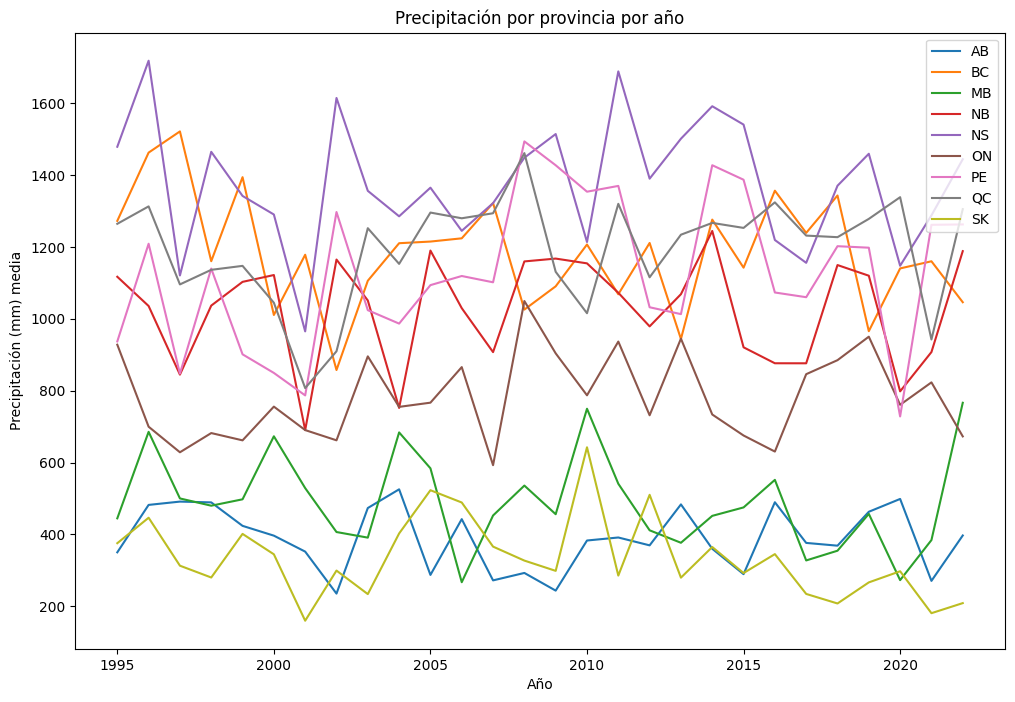

In [47]:
"""Precipitación por año"""
provinces = df2['province'].unique()
plt.figure(figsize=(12, 8))
for province in provinces:
   data = df2[(df2['province'].str.strip() == province)].copy()
   precipitation_mean = data.groupby(['year'])['precipitation(mm)'].mean().reset_index()
   plt.plot(precipitation_mean['year'], precipitation_mean['precipitation(mm)'], label=province)
plt.title("Precipitación por provincia por año")
plt.xlabel("Año")
plt.ylabel("Precipitación (mm) media")
plt.legend()
plt.show()

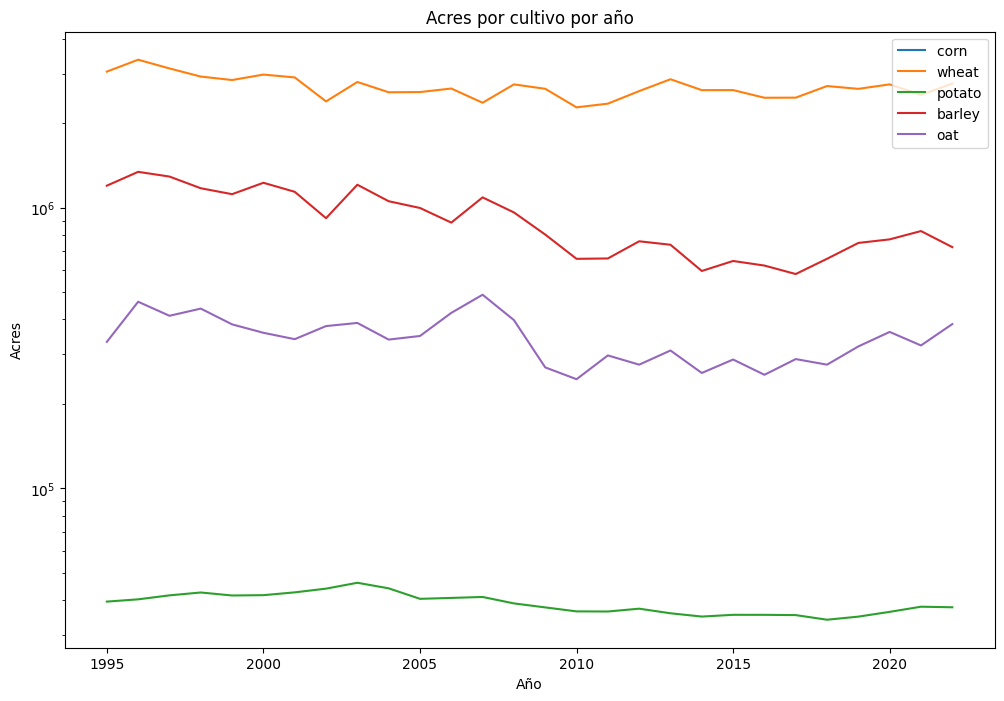

In [48]:
"""Acres por cultivo por año"""
crops = df2['crop'].unique()
plt.figure(figsize=(12, 8))
plt.yscale('log')
for crop in crops:
   data = df2[(df2['crop'].str.strip() == crop)].copy()
   precipitation_mean = data.groupby(['year'])['harvested area (acres)'].mean().reset_index()
   plt.plot(precipitation_mean['year'], precipitation_mean['harvested area (acres)'], label=crop)
plt.title("Acres por cultivo por año")
plt.xlabel("Año")
plt.ylabel("Acres")
plt.legend()
plt.show()

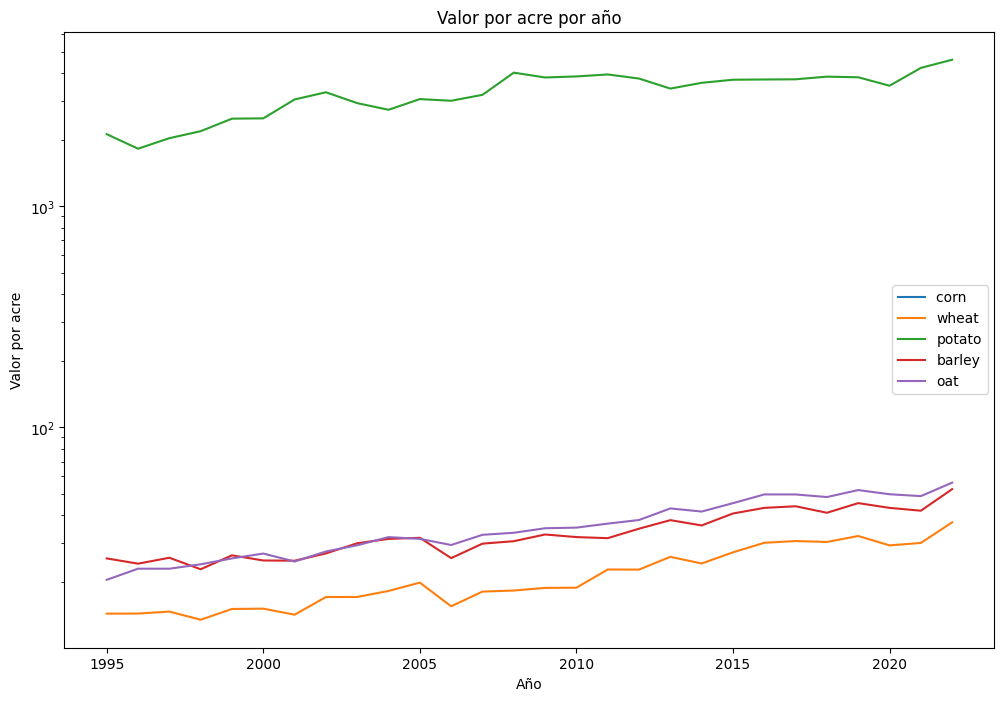

In [49]:
"""Valor por acre por cultivo por año"""
crops = df2['crop'].unique()
plt.figure(figsize=(12, 8))
plt.yscale('log')
for crop in crops:
   data = df2[(df2['crop'].str.strip() == crop)].copy()
   precipitation_mean = data.groupby(['year'])['farm_gate_value_per_acre'].mean().reset_index()
   plt.plot(precipitation_mean['year'], precipitation_mean['farm_gate_value_per_acre'], label=crop)
plt.title("Valor por acre por año")
plt.xlabel("Año")
plt.ylabel("Valor por acre")
plt.legend()
plt.show()

<Axes: xlabel='province', ylabel='crop'>

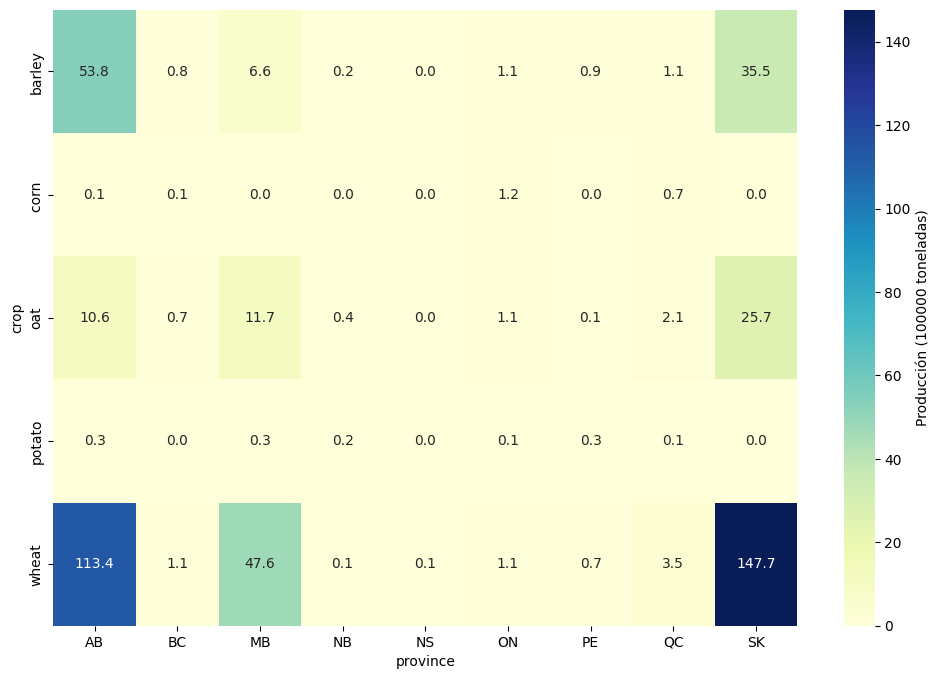

In [51]:
"""Producción por provincia por cultivo en 2022"""
data = df2[(df2['year'].astype(int) == 2022)].copy()
result = data.groupby(['crop', 'province'])['production (tonnes)'].sum().reset_index()
# Dividir los valores por 1000000 y redondear a un decimal
result['production (tonnes)'] = (result['production (tonnes)'] / 100000).round(2)
heatmap_data = result.pivot(index='crop', columns='province', values='production (tonnes)')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Producción (100000 toneladas)'})

<Axes: xlabel='province', ylabel='crop'>

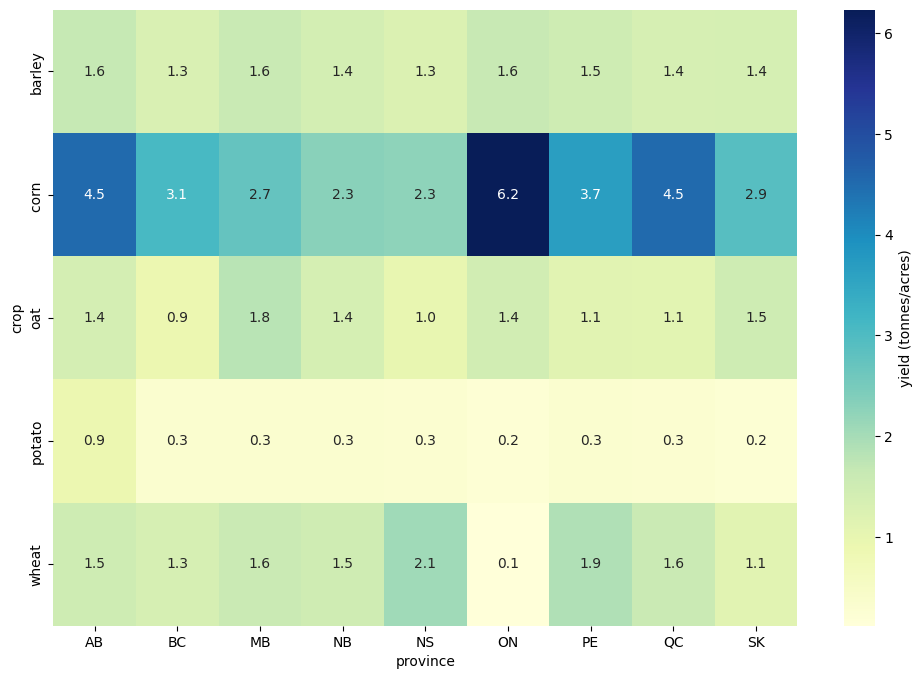

In [52]:
"""Toneladas por Acre por provincia por cultivo en 2022"""
data = df2[(df2['year'].astype(int) == 2022)].copy()
result = data.groupby(['crop', 'province'])['yield (tonnes/acres)'].sum().reset_index()
heatmap_data = result.pivot(index='crop', columns='province', values='yield (tonnes/acres)')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'yield (tonnes/acres)'})

## Modelado y predicción

TODO


## Generación de Conclusiones

TODO